In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.dates as mdates

In [50]:
# Load the dataset
data= pd.read_csv('/kaggle/input/gold-price-10-years-20132023/Gold Price (2013-2023).csv')
data

,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00",159.62K,0.74%
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55",NaN,0.30%
...,...,...,...,...,...,...,...
2578,01/08/2013,"1,663.20","1,651.50","1,662.60","1,648.80",0.13K,0.97%
2579,01/07/2013,"1,647.20","1,657.30","1,663.80","1,645.30",0.09K,-0.16%
2580,01/04/2013,"1,649.90","1,664.40","1,664.40","1,630.00",0.31K,-1.53%
2581,01/03/2013,"1,675.60","1,688.00","1,689.30","1,664.30",0.19K,-0.85%


In [51]:
data.describe()

,Date,Price,Open,High,Low,Vol.,Change %
count,2583,2583,2583,2583,2583,2578,2583
unique,2583,2072,2061,2044,2019,1550,474
top,01/02/2013,"1,294.30","1,325.00","1,304.80","1,314.00",0.02K,0.00%
freq,1,5,5,6,5,48,29


In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2583 non-null   object
 1   Price     2583 non-null   object
 2   Open      2583 non-null   object
 3   High      2583 non-null   object
 4   Low       2583 non-null   object
 5   Vol.      2578 non-null   object
 6   Change %  2583 non-null   object
dtypes: object(7)
memory usage: 141.4+ KB


In [53]:
# Ensure the dataframe is sorted by date
data = data.sort_values('Date')

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

# Convert columns to numeric, handling commas and ignoring errors
data = data.apply(lambda x: pd.to_numeric(x.astype(str).str.replace(',', '').replace('K', ''), errors='coerce'))

In [54]:
# Drop the last two columns
data.drop(data.columns[-2:], axis=1, inplace=True)

# Check for NaN values
print(data.isnull().sum())

# Print the columns after dropping
print("Columns after dropping:", data.columns)

Price    0
Open     0
High     0
Low      0
dtype: int64
Columns after dropping: Index(['Price', 'Open', 'High', 'Low'], dtype='object')


In [55]:
# Normalize the dataset using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values)


In [56]:
# Create a function to prepare the dataset for LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        dataX.append(dataset[i:(i + time_step), :])
        dataY.append(dataset[i + time_step, 0])  # Predicting the first feature 
    return np.array(dataX), np.array(dataY)

In [57]:
# Define the time step
time_step = 30

# Split data into training and testing
training_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - training_size
train_data, test_data = scaled_data[0:training_size, :], scaled_data[training_size:len(scaled_data), :]


In [58]:
# Create the training and testing datasets
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [59]:
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(2035, 30, 4) (486, 30, 4)
(2035,) (486,)


In [60]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(80, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(LSTM(70, return_sequences=False))
model.add(Dense(50))
model.add(Dense(1))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [61]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 30, 80)         │        27,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 70)             │        42,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 50)             │         3,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,081 (285.47 KB)

 Trainable params: 73,081 (285.47 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [63]:
# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=200)

Epoch 1/200
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0506
Epoch 2/200
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0215
Epoch 3/200
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0174
Epoch 4/200
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0149
Epoch 5/200
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0145
Epoch 6/200
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0143
Epoch 7/200
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0121
Epoch 8/200
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0121
Epoch 9/200
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0110
Epoch 10/200
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0102
Epoch 11/200
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0094
Epoch 12/200
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0092
Epoch 13/200
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0090
Epoch 14/200
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0092
E

In [64]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual values
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], scaled_data.shape[1]-1))), axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1]-1))), axis=1))[:, 0]
y_train = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], scaled_data.shape[1]-1))), axis=1))[:, 0]
y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1]-1))), axis=1))[:, 0]


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [65]:
# Calculate RMSE and R² score and Accuracy
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
train_r2 = r2_score(y_train, train_predict)
test_r2 = r2_score(y_test, test_predict)
train_acc = 1- mean_absolute_percentage_error(y_train, train_predict)
test_acc = 1- mean_absolute_percentage_error(y_test, test_predict)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

print(f'Train R² score: {train_r2}')
print(f'Test R² score: {test_r2}')

print(f'Train Accuracy: {train_acc}')
print(f'Test Accuracy: {test_acc}')


Train RMSE: 12.82907658675572
Test RMSE: 65.37403643572326
Train R² score: 0.9973975958876613
Test R² score: 0.9444945446376874
Train Accuracy: 0.9932169572575031
Test Accuracy: 0.968927153949379


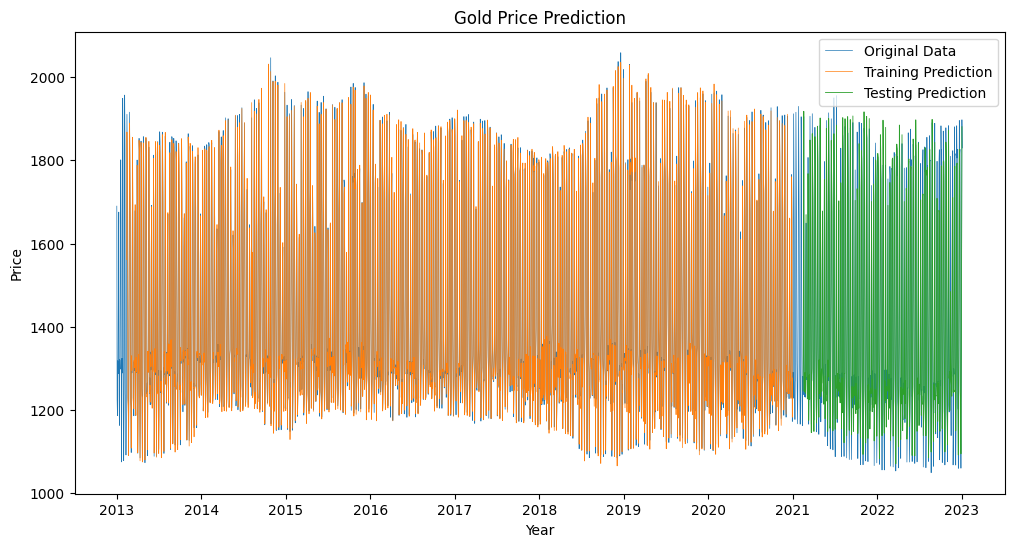

In [75]:
# Plotting
look_back = time_step
train_predict_plot = np.empty_like(scaled_data[:, 0])
train_predict_plot[:] = np.nan
train_predict_plot[look_back:len(train_predict) + look_back] = train_predict

test_predict_plot = np.empty_like(scaled_data[:, 0])
test_predict_plot[:] = np.nan
test_predict_plot[len(train_predict) + (look_back * 2) + 1:len(scaled_data) - 1] = test_predict

plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(scaled_data)[:, 0], label='Original Data',linewidth=0.5)
plt.plot(train_predict_plot, label='Training Prediction',linewidth=0.5)
plt.plot(test_predict_plot, label='Testing Prediction',linewidth=0.6)
plt.title('Gold Price Prediction')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()

# Set x-axis ticks to display specific years with empty spaces
years = np.arange(2013, 2024)
positions = np.arange(0, len(scaled_data), len(scaled_data) // (len(years)-1))
plt.xticks(positions, years)

plt.show()